In [1]:
%pip install --upgrade tensorflow
%pip install --upgrade tensorflow-metal

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Deep Learning based Brain Tumour Classification using CNNs and MR Imaging

## CNN Model using Tensorflow

In this notebook, we will also delve into TensorFlow 2.16+, which introduces several enhancements and features that streamline the model development process. TensorFlow 2.16 includes improved data augmentation capabilities, advanced model-building APIs, and optimized performance for faster computation and training. These features will be leveraged to demonstrate how state-of-the-art machine learning techniques can be applied to the critical field of medical imaging, potentially leading to breakthroughs in the early detection and classification of brain tumors.

## Understanding Brain Tumors and Detection Methods
    
A brain tumor represents an abnormal mass or growth of cells in the brain, existing within the confined space of the skull. This condition can lead to serious complications due to increased intracranial pressure and potential brain damage. Tumors can be benign (noncancerous) or malignant (cancerous), and their early detection and accurate classification are critical for effective treatment planning, underscoring the importance of advancements in medical imaging.

Deep learning, particularly in the realm of healthcare, has brought significant improvements in diagnosing various conditions, including brain tumors. The World Health Organization emphasizes the importance of accurate brain tumor diagnosis, which includes detecting the presence of a tumor, pinpointing its location, and classifying its type and grade. This notebook explores the use of Convolutional Neural Networks (CNNs) in a multi-task approach for the detection, classification, and location identification of brain tumors using MRI images, showcasing the potential of these models to revolutionize diagnostics in neurology.

## About the Dataset

This dataset is a compilation of two primary datasets: figshare and Br35H. The dataset comprises a total of `7023` human **brain MRI images**, categorized into four distinct classes. The dataset focuses on brain tumors and their classification. The four classes are as follows:

- **Glioma**: Cancerous brain tumors in glial cells.
- **Meningioma**: Non-cancerous tumors originating from the meninges.
- **No Tumor**: Normal brain scans without detectable tumors.
- **Pituitary**: Tumors affecting the pituitary gland, which can be cancerous or non-cancerous.

Advancing the development of machine learning models for tumor classification is crucial for driving progress in the field of neurology and making a significant impact on the lives of individuals. These models have the potential to enhance medical research, improve diagnostic accuracy, and contribute to effective treatment strategies for various types of tumors. By leveraging machine learning techniques, we can significantly aid in the advancement of neurology and ultimately improve healthcare outcomes for people affected by tumors.
    
The "No Tumor" class images were obtained from the `Br35H dataset`.

The data link and complete description here [`Brain Tumor Data on Kaggle`](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)


In [2]:
# General Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.metrics import confusion_matrix

# Neural Network imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

# Image augmentation importrs
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomTranslation

# Training Model callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Check if GPU is available
print(f'Tensorflow Version: {tf.__version__}')

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("GPU Available:", gpu_devices)
    # Additional print to confirm Metal API usage if needed
    # This is more about ensuring TensorFlow is set up correctly for M1 Macs
    # TensorFlow will automatically use Metal for GPU acceleration on M1 Macs if available
else:
    print("GPU is not available. Ensure TensorFlow-Metal is installed for M1 MacBooks.")

SEED = 111

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

Tensorflow Version: 2.17.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Pre Processing

In [3]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}
    
    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)
            
    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)
            
    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels), 
                                 num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
# Getting data labels
USER_PATH = "brain-tumor-mri-dataset"
train_paths, train_index = get_data_labels(USER_PATH + '/Training', random_state=SEED)
test_paths, test_index = get_data_labels(USER_PATH + '/Testing', random_state=SEED)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

# Prepare datasets with 4 classes and grayscale
batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)

# Output to show datasets
print(f"\nTraining dataset: {train_ds}")
print(f"\nTesting dataset: {test_ds}")

# Class mappings
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311

Training dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 168, 168, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Testing dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 168, 168, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


2024-07-13 18:23:02.287886: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-07-13 18:23:02.287928: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-13 18:23:02.287937: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-13 18:23:02.287962: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-13 18:23:02.287982: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Data Visualisation

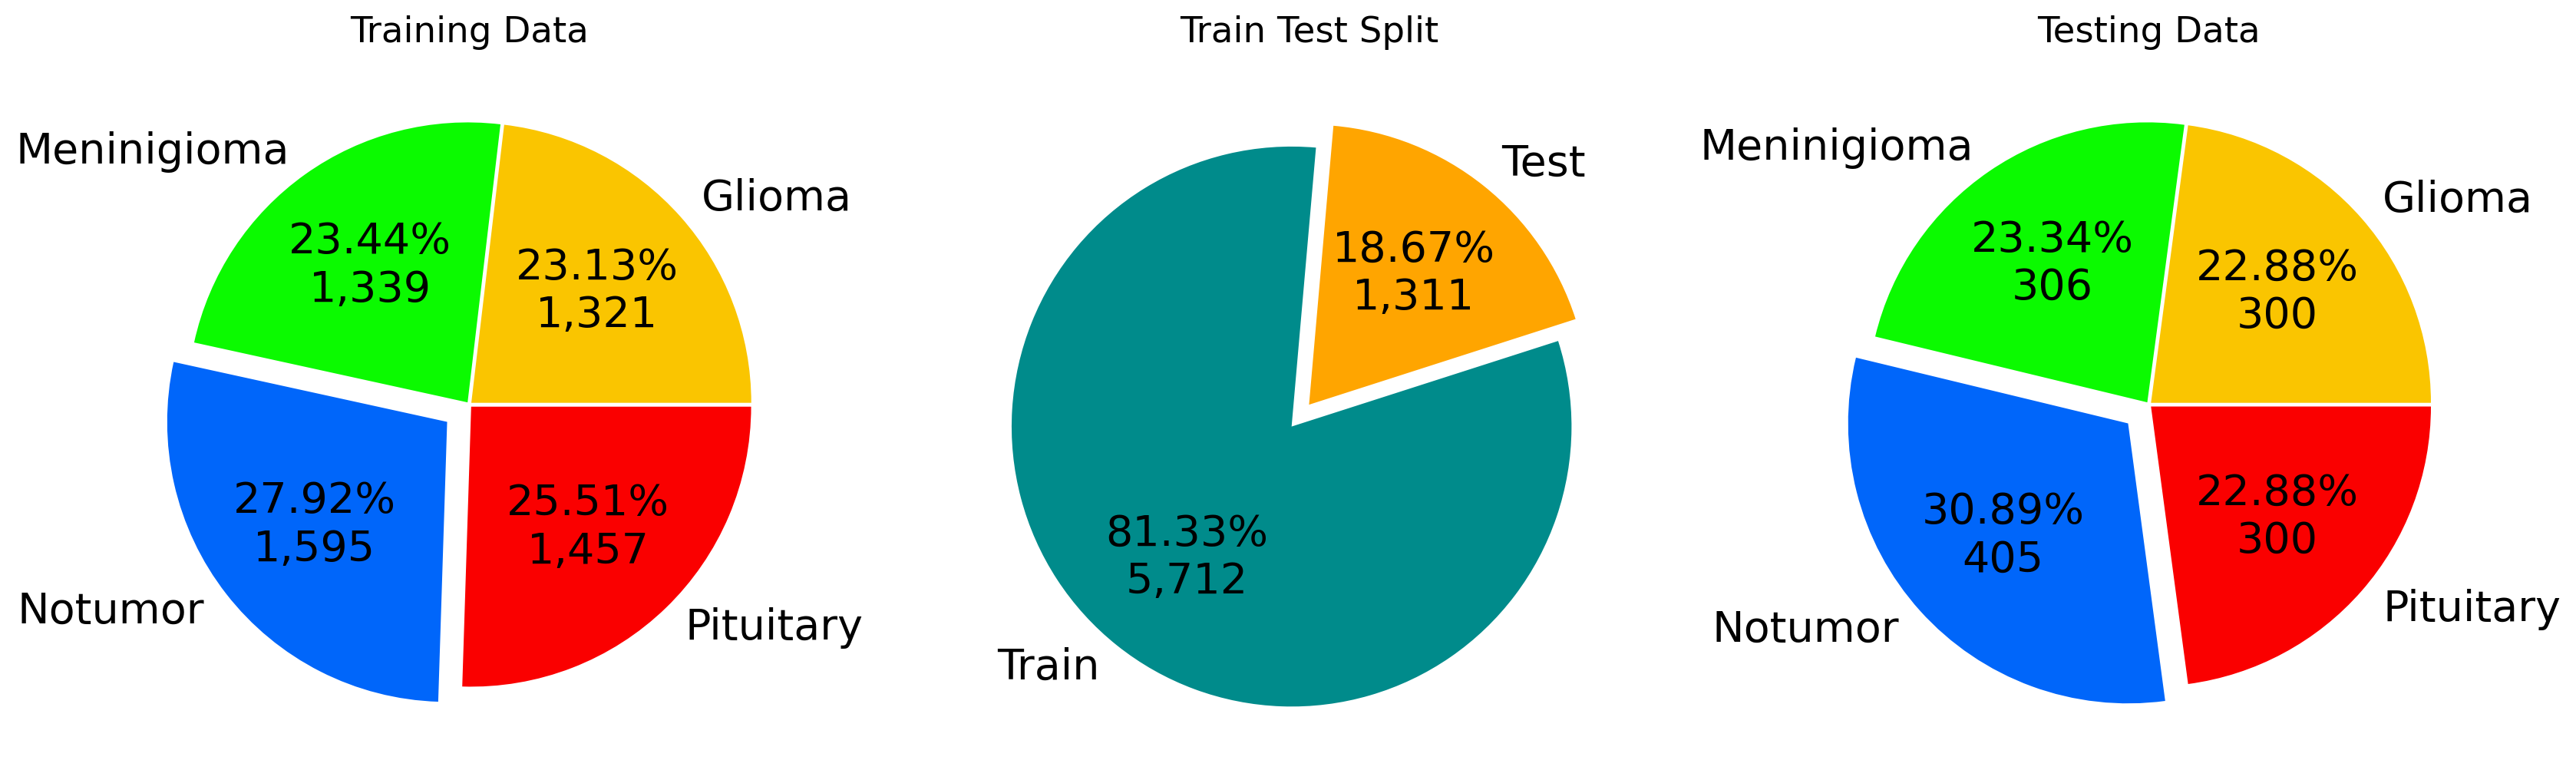

In [6]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
class_counts = [len([x for x in train_index if x == label]) for label in set(train_index)]
ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=[label for label in class_names],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 20}
)

# Plotting distribution of train test split
ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(train_index), len(test_index)],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_index), len(test_index)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)

# Plotting testing data types
class_counts = [len([x for x in test_index if x == label]) for label in set(test_index)]
ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts,
    labels=[label for label in class_names],
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 20} 
)

plt.show()

### Viewing Image Data

Note that the color channels are all the same, grayscale, so we will use only one channel.

In [7]:
# Function to display a list of images based on the given index
def show_images(paths, label_paths, class_mappings, index_list=range(10), im_size=250, figsize=(12, 8)):
    
    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    index_to_class = {v: k for k, v in class_mappings.items()}
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()
    
    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        image = load_img(paths[index], target_size=(im_size, im_size), color_mode='grayscale')
        ax[i].imshow(image, cmap='Greys_r')
        class_name = index_to_class[label_paths[index]]
        ax[i].set_title(f'{index}: {class_name}')
        ax[i].axis('off')
        
    plt.tight_layout()
    plt.show()

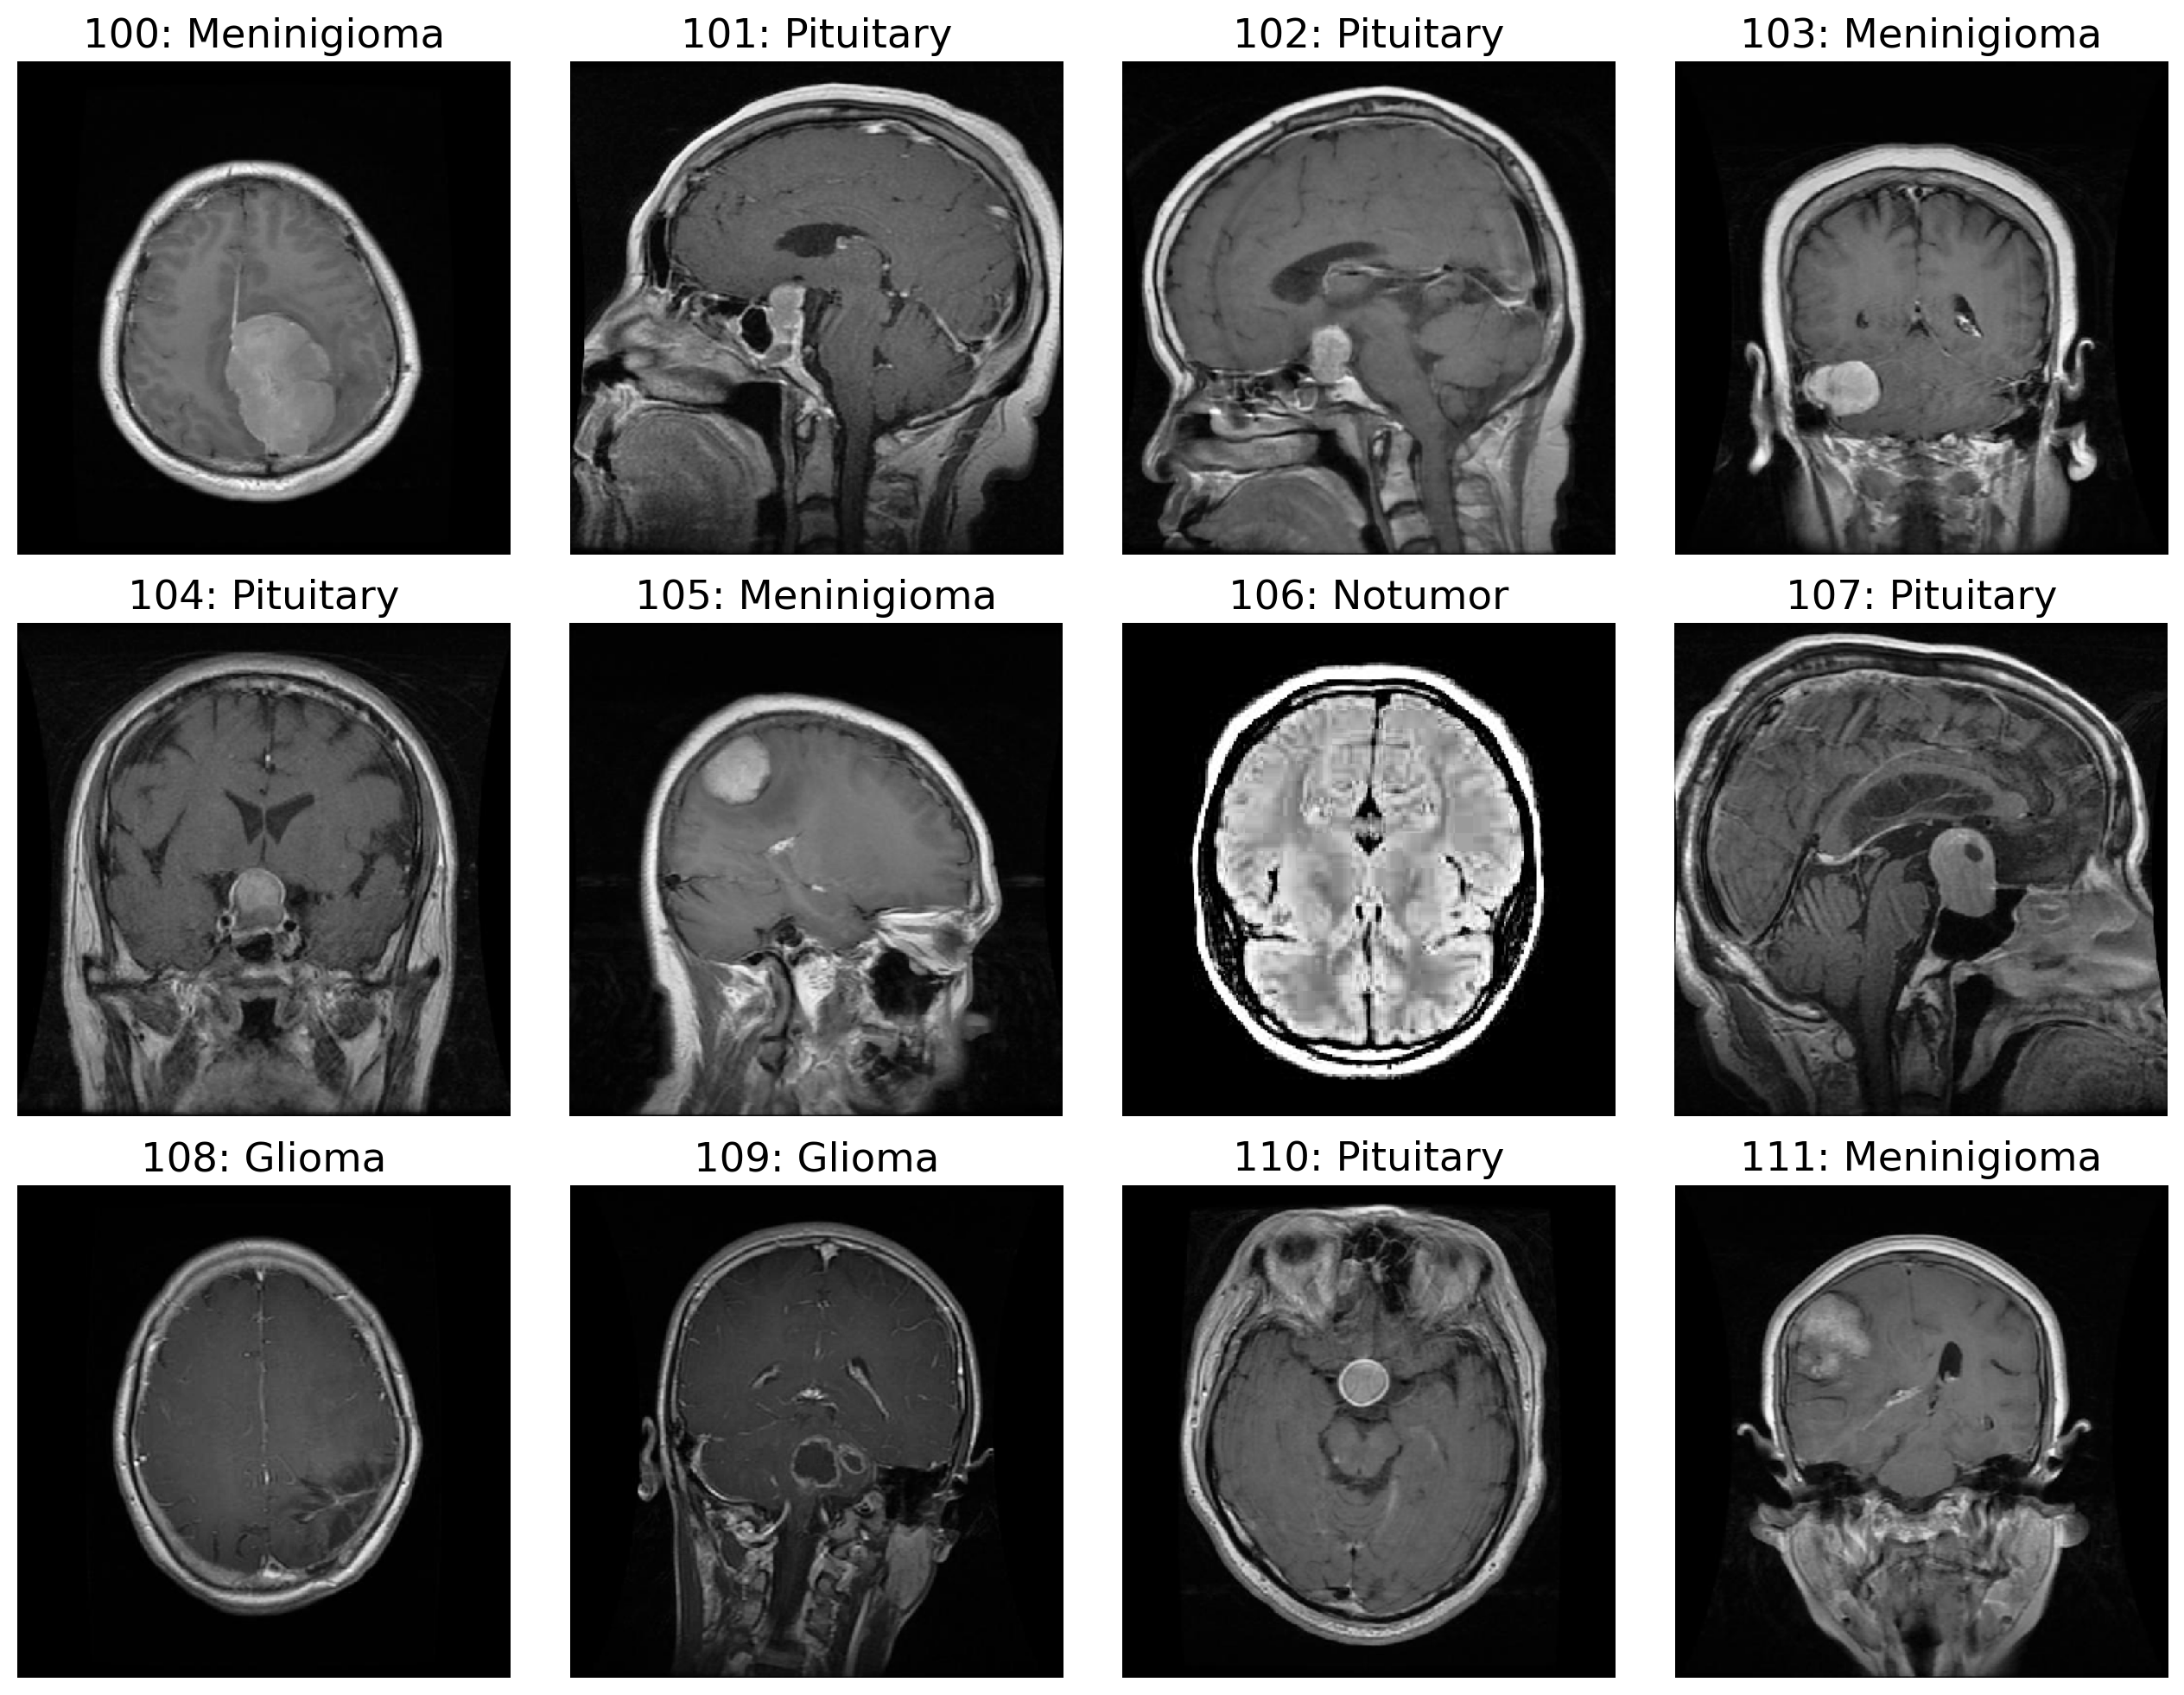

In [8]:
# Four images from different angles
show_images(train_paths, train_index, class_mappings, im_size=350, figsize=(13,10),
            index_list=range(100, 112))

## Training Setup

### Data Augmentation sequential model

In [9]:
# Data augmentation sequential model
data_augmentation = Sequential([
    # RandomFlip("horizontal_and_vertical"),
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label

# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label

# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

### Visualising the augmented images


In [10]:
# Function to display augmented images
def plot_augmented_images(dataset, shape, class_mappings, figsize=(15, 6)):
    plt.figure(figsize=figsize)
    index_to_class = {v: k for k, v in class_mappings.items()}
    for images, label in dataset.take(1):
        i = 0
        for i in range(shape[0]*shape[1]):
            ax = plt.subplot(shape[0], shape[1], i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            plt.title(index_to_class[label.numpy()[i]])
            plt.axis("off")
            i += 1
            
    plt.tight_layout()
    plt.show()

2024-07-13 18:23:14.228400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-07-13 18:23:14.776165: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


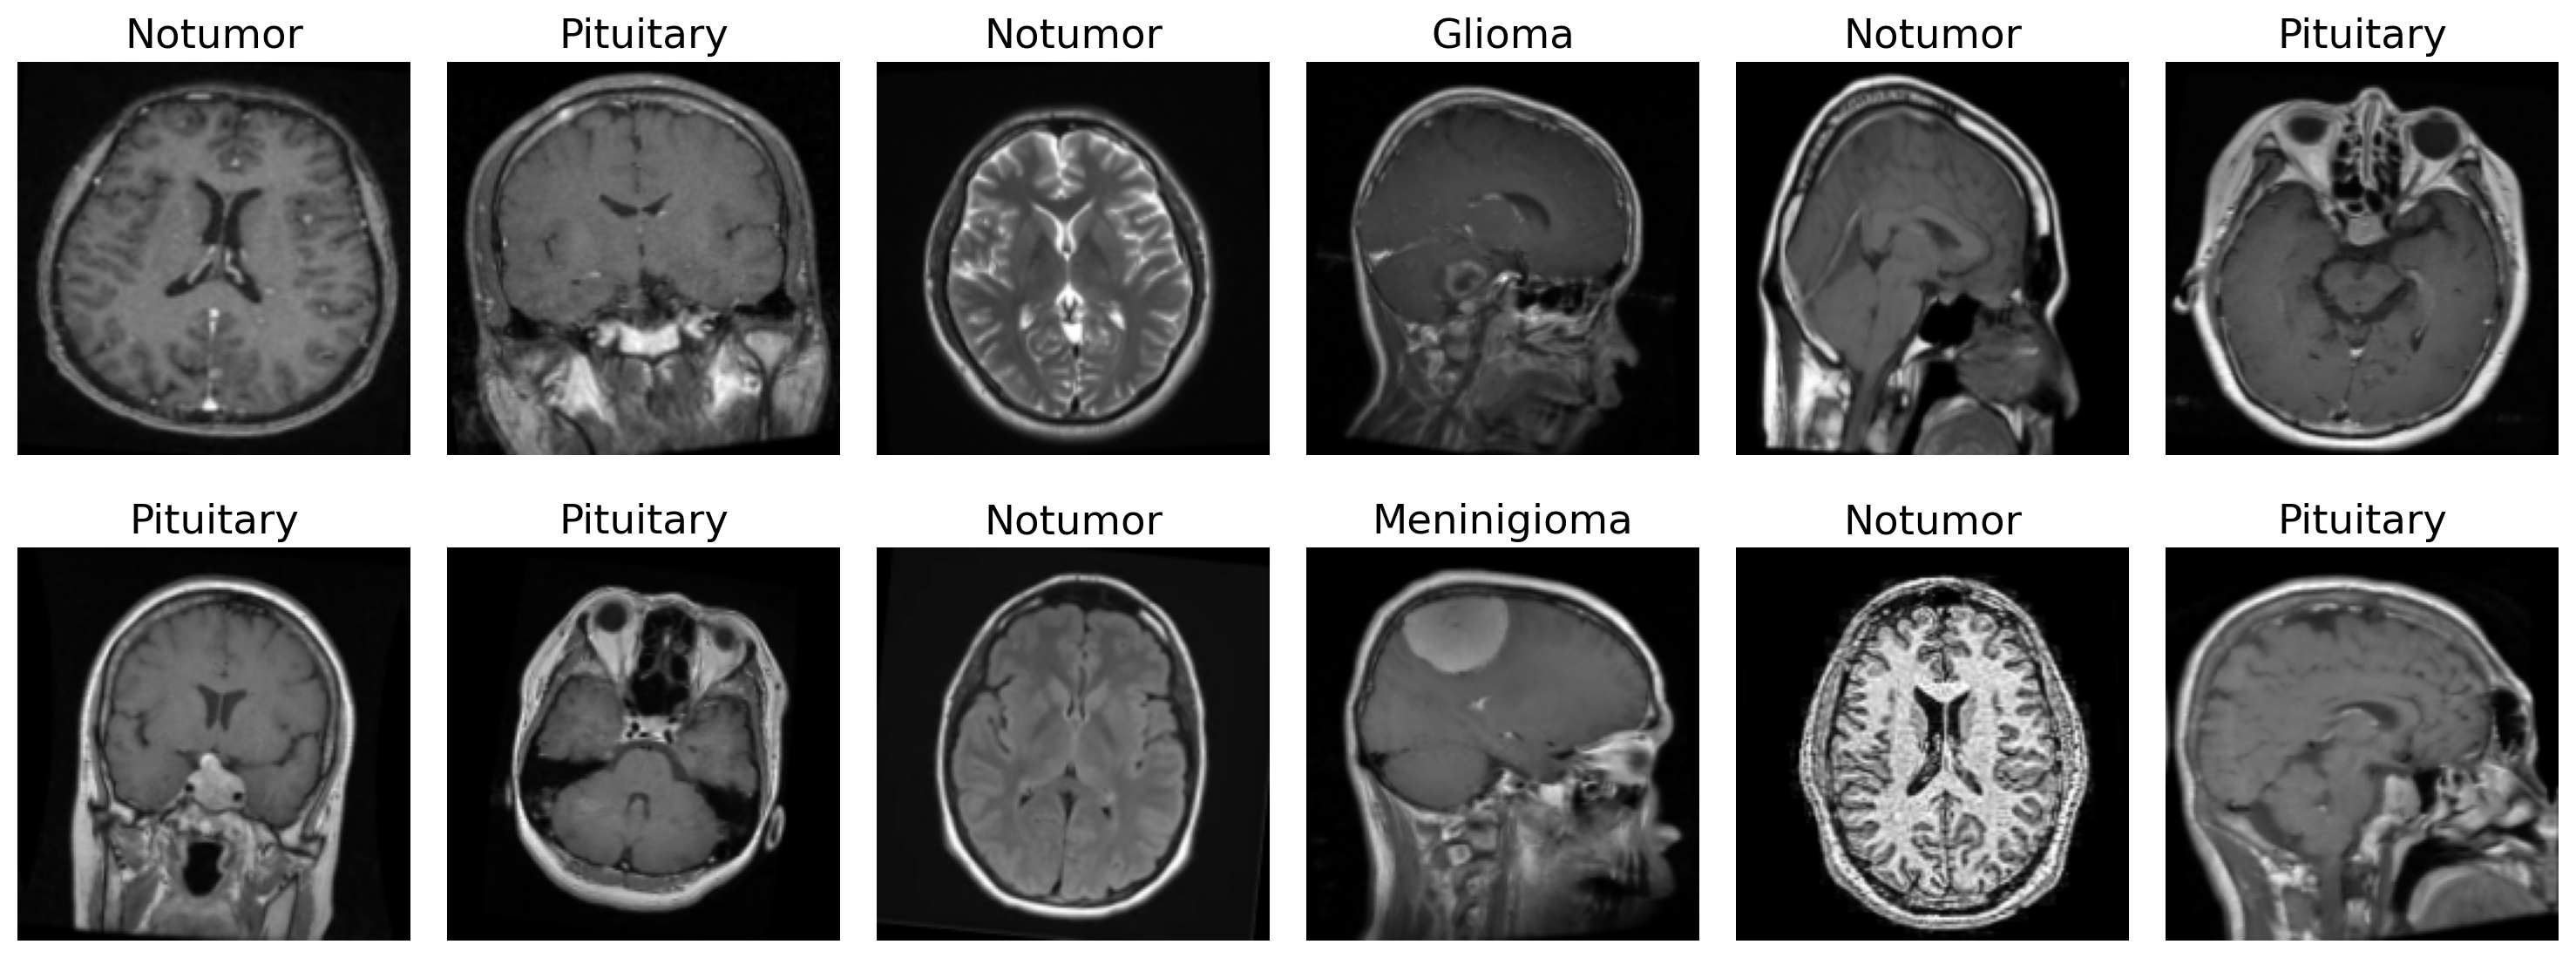

In [11]:
# Displaying augmented images
plot_augmented_images(train_ds_preprocessed, shape=(2, 6), class_mappings=class_mappings)

### Setting up basic parameters

This Python code snippet is part of a machine learning project using TensorFlow, aimed at classifying images of tumors. It sets up some basic parameters for the model, including the number of classes, the shape of the images, the number of training epochs, and the batch size. Additionally, it defines a function to encode labels into a one-hot format and applies this function to preprocess the training and testing datasets.

Firstly, [`num_classes`] is determined by counting the number of keys in [`class_mappings`], which likely maps class labels to their respective indices. This is crucial for a classification task as it defines the output layer size of the model. [`image_shape`] is set based on [`image_dim`], which presumably contains the height and width of the images. The `1` indicates that the images are in grayscale rather than color (which would have used `3` for RGB channels).

The number of epochs [`epochs`] is set to `50`, indicating the model will go through the entire dataset 50 times during training. The batch size, which affects memory usage and training speed, is printed but not explicitly set in this snippet, implying it's defined elsewhere.

The [`encode_labels`] function is defined to take an image and its label as input, returning the image unchanged and the label encoded as a one-hot vector. This encoding is necessary for TensorFlow's categorical cross-entropy loss function, which expects labels to be in this format. The [`tf.one_hot`]function is used for this purpose, with [`depth=num_classes`] ensuring the one-hot vectors have a length equal to the number of classes.

Finally, the `.map` method is used to apply [`encode_labels`] to each element in [`train_ds_preprocessed`] and [`test_ds_preprocessed`]. These datasets are likely instances of [`tf.data.Dataset`], containing the images and their labels. The [`num_parallel_calls=tf.data.AUTOTUNE`] argument optimizes the number of parallel processing tasks, improving preprocessing speed.

This setup is a common pattern in TensorFlow projects for image classification, preparing the data for efficient training and evaluation by the model.

In [12]:
# Classes and Image shape: height, width, grayscale
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1) 

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label): 
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


## Building CNN Model

### Understanding Convolutional Layer (Conv2D)
    
- **Filters**: Number of output filters in the convolution. 
  - *Example*: 32 filters.
  - *Math*: Determines the depth of the output feature map.
  - *Intuition*: Captures a variety of features from the input.
- **Kernel Size**: Size of the convolution window.
  - *Example*: `(3, 3)` is a common kernel size.
  - *Math*: Defines the area of input considered during each convolution.
  - *Intuition*: Small kernels capture local features, while larger kernels capture more global features.
- **Strides**: Step size at which the convolution window moves across the input.
  - *Example*: `(1, 1)` means moving one pixel at a time.
  - *Math*: Affects the dimensionality of the output feature map.
  - *Intuition*: Larger strides can reduce spatial dimensions, capturing broader features.
- **Padding**: Adds zeros to the input's edges to maintain size.
  - *Example*: 'Same' padding retains the input size in the output.
  - *Math*: Influences the size of the output feature map.
  - *Intuition*: Ensures edge features are processed effectively.
- **Activation**: Non-linear function applied to introduce non-linearity.
  - *Example*: ReLU (Rectified Linear Unit).
  - *Math*: Applies non-linearity to the convolution output.
  - *Intuition*: Allows the network to learn complex patterns.

### Understanding Pooling Layer (MaxPooling2D, AvgPooling2D)
    
- **Pool Size**: The size of the pooling window.
  - *Example*: `(2, 2)` reduces the spatial dimensions by half.
  - *Math*: Downsamples the input representation.
  - *Intuition*: Makes the features more robust to variations and translations.
- **Strides** and **Padding**: Similar to convolutional layers, they influence the output size.
  - *Example*: Strides often equal the pool size to avoid overlap.

### Understanding Beta Parameters in Adam Optimizer and Weight Updates </div>

The Adam optimizer adapts the learning rate for each weight of the model by calculating the first and second moments of the gradients. Here's an in-depth look at how this works:

##### **Beta Parameters (beta_1 and beta_2)**
- **beta_1**: The exponential decay rate for the first moment (mean) of the gradients.
  - **Math**: $\hat{m}_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g_t$
  - *where*: $m_t$ is the bias-corrected first moment estimate, $m_{t-1}$ is the first moment at the previous time step, and $g_t$ is the gradient at time step $t$.
  - **Intuition**: Controls the extent to which the optimizer relies on the previous gradients. A higher `beta_1` maintains a longer memory, leading to smoother updates, while a lower value makes the optimizer more responsive to recent changes.
- **beta_2**: The exponential decay rate for the second moment (variance) of the gradients.
  - **Math**: $\hat{v}_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g_t^2$
  - *where*: $v_t$ is the bias-corrected second moment estimate, and $g_t^2$ is the square of the gradient at time step $t$.
  - **Intuition**: Determines how the optimizer adapts the learning rate based on the history of squared gradients. Higher `beta_2` values result in more stable but conservative updates, while lower values allow for more aggressive adjustments.

##### **Weight Update Equation**
The weight update in Adam is influenced by these moment estimates, guiding the amount of adjustment made to weights during each training iteration. The integrated update equation is:
$$ \theta_{t+1} = \theta_t - \frac{\eta \cdot \hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} $$
where:
- $\theta_{t+1}$ is the updated weight.
- $\theta_t$ is the current weight.
- $\eta$ is the learning rate.
- $\hat{m}_t$ is the bias-corrected first moment estimate.
- $\hat{v}_t$ is the bias-corrected second moment estimate.
- $\epsilon$ is a small constant (e.g., 1e-8) to prevent division by zero.

This equation demonstrates how the optimizer uses the first and second moment estimates to adaptively adjust the learning rate for each weight, helping to accelerate convergence and improve the training process's efficiency.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 164, 164, 64)   │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

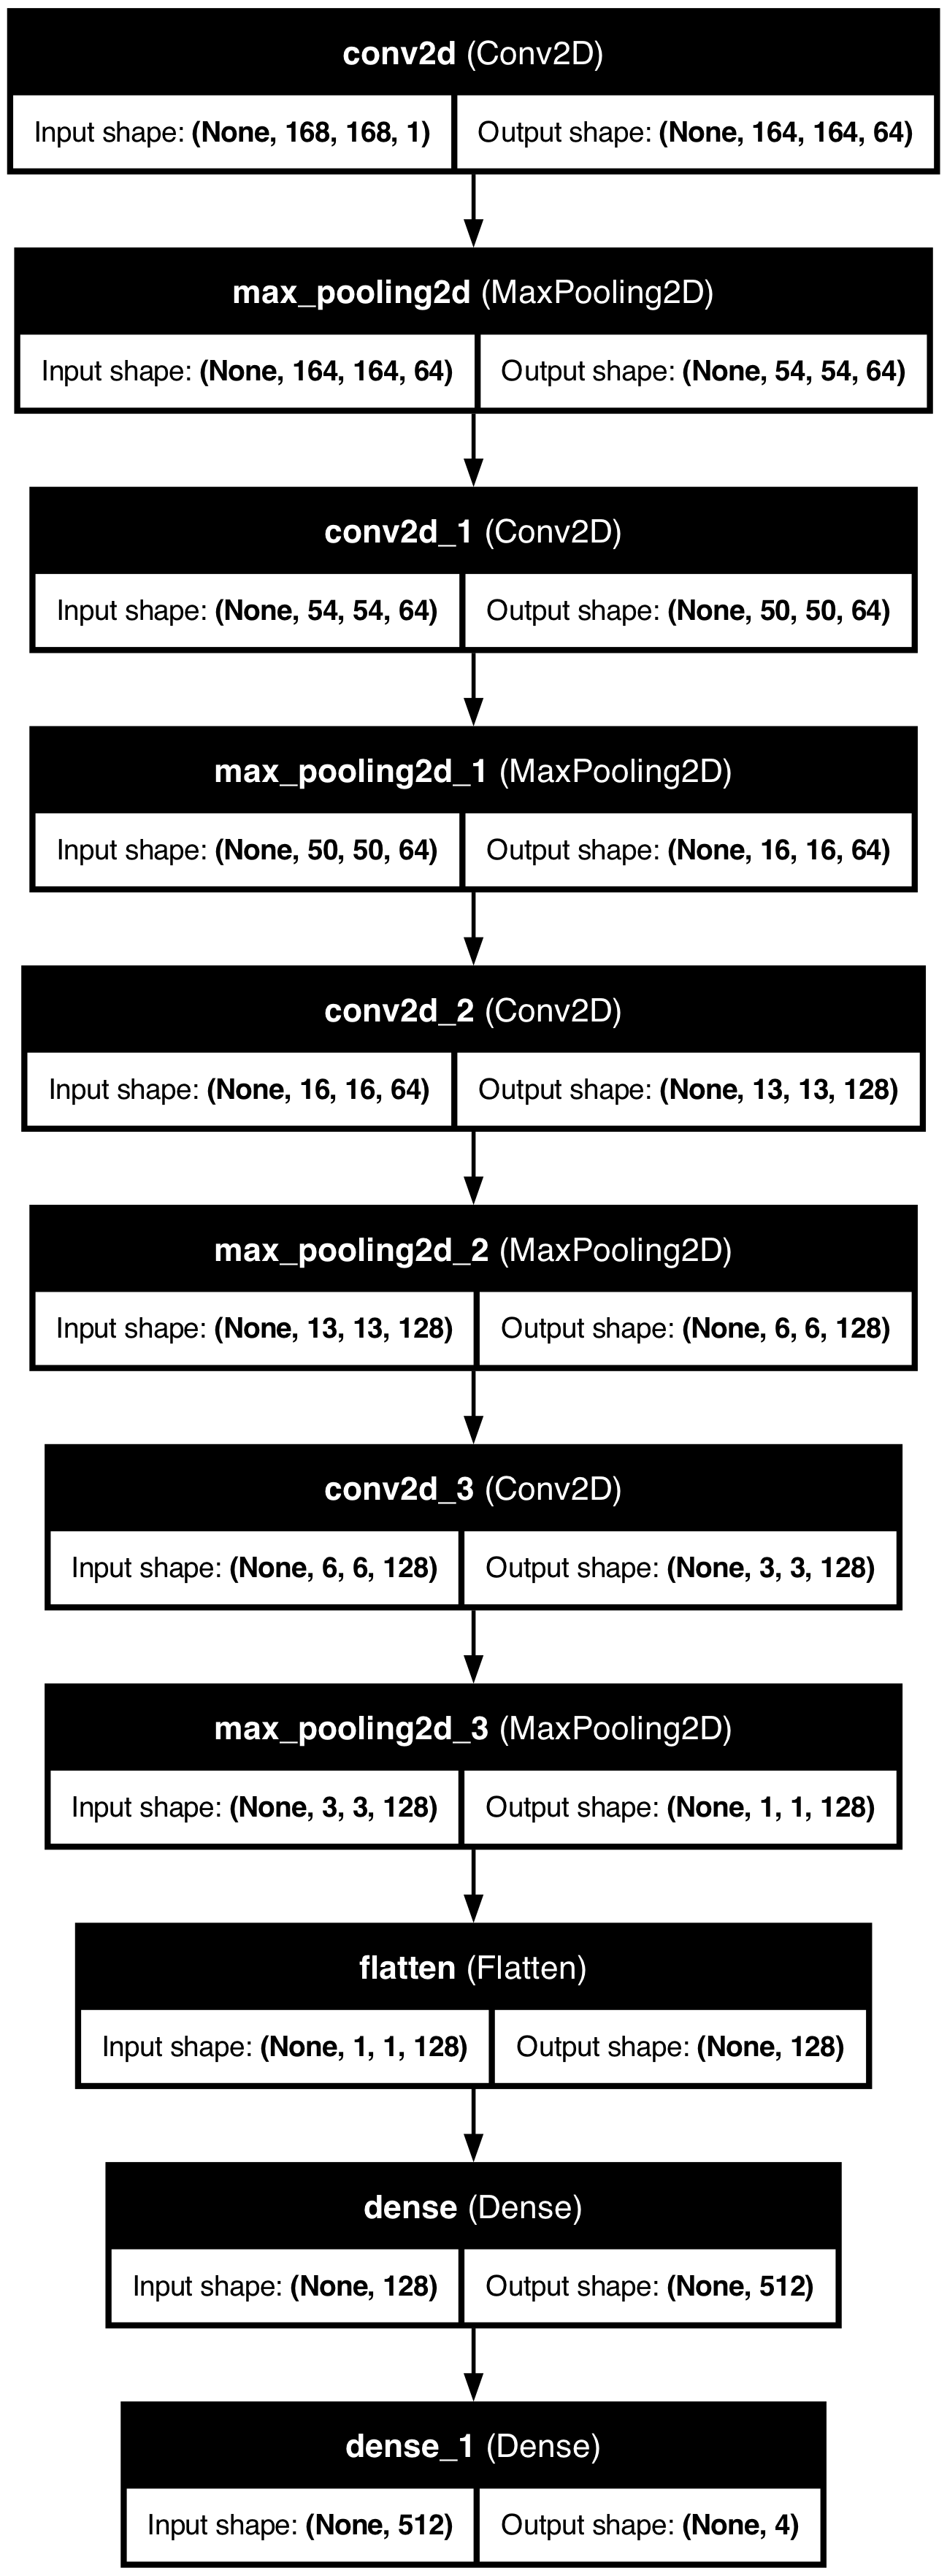

In [13]:
# Building model
model = Sequential([
    # Input tensor shape
    Input(shape=image_shape),
    
    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers 
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model.summary()

# Compilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

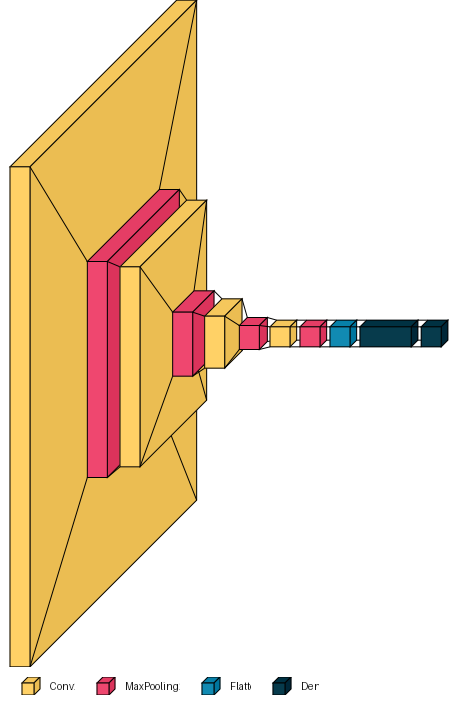

In [27]:
from visualkeras import layered_view 
# Visualize the model
layered_view(model, legend=True, draw_volume=True, max_xy=500, to_file='model.png')

## CNN Training
    
`ReduceLROnMultipleAccuracies Callback`: This TensorFlow callback reduces the learning rate when validation accuracy exceeds a set threshold. It's useful for fine-tuning and preventing overfitting by making smaller updates to the model's weights as it learns.

In [28]:
# Custom callback for reducing learning rate at accuracy values
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [29]:
# Callbacks for improved covergence of gradient and best test accuracy
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - accuracy: 0.4948 - loss: 1.0916 - val_accuracy: 0.7155 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.7956 - loss: 0.5329 - val_accuracy: 0.7857 - val_loss: 0.5675 - learning_rate: 0.0010
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.8667 - loss: 0.3577 - val_accuracy: 0.8589 - val_loss: 0.3593 - learning_rate: 0.0010
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9039 - loss: 0.2532 - val_accuracy: 0.8886 - val_loss: 0.2779 - learning_rate: 0.0010
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.9330 - loss: 0.1794 - val_accuracy: 0.9062 - val_loss: 0.2460 - learning_rate: 0.0010
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9427 - loss: 0.1587 - val_accuracy: 0.9008 - val_loss: 0.2655 - learning_rate: 0.0010
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.9513 - l

## Model Evaluation

### Loading saved Model and Evaluating Accuracy on Test Data

In [30]:
# Loading saved model
model = load_model('model.keras')

# Evaluate model and test data accuracy
test_loss, test_acc = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9924 - loss: 0.0961
Test accuracy: 99.1609%


### Plotting Training/Validation Accuracy and Loss vs Epochs

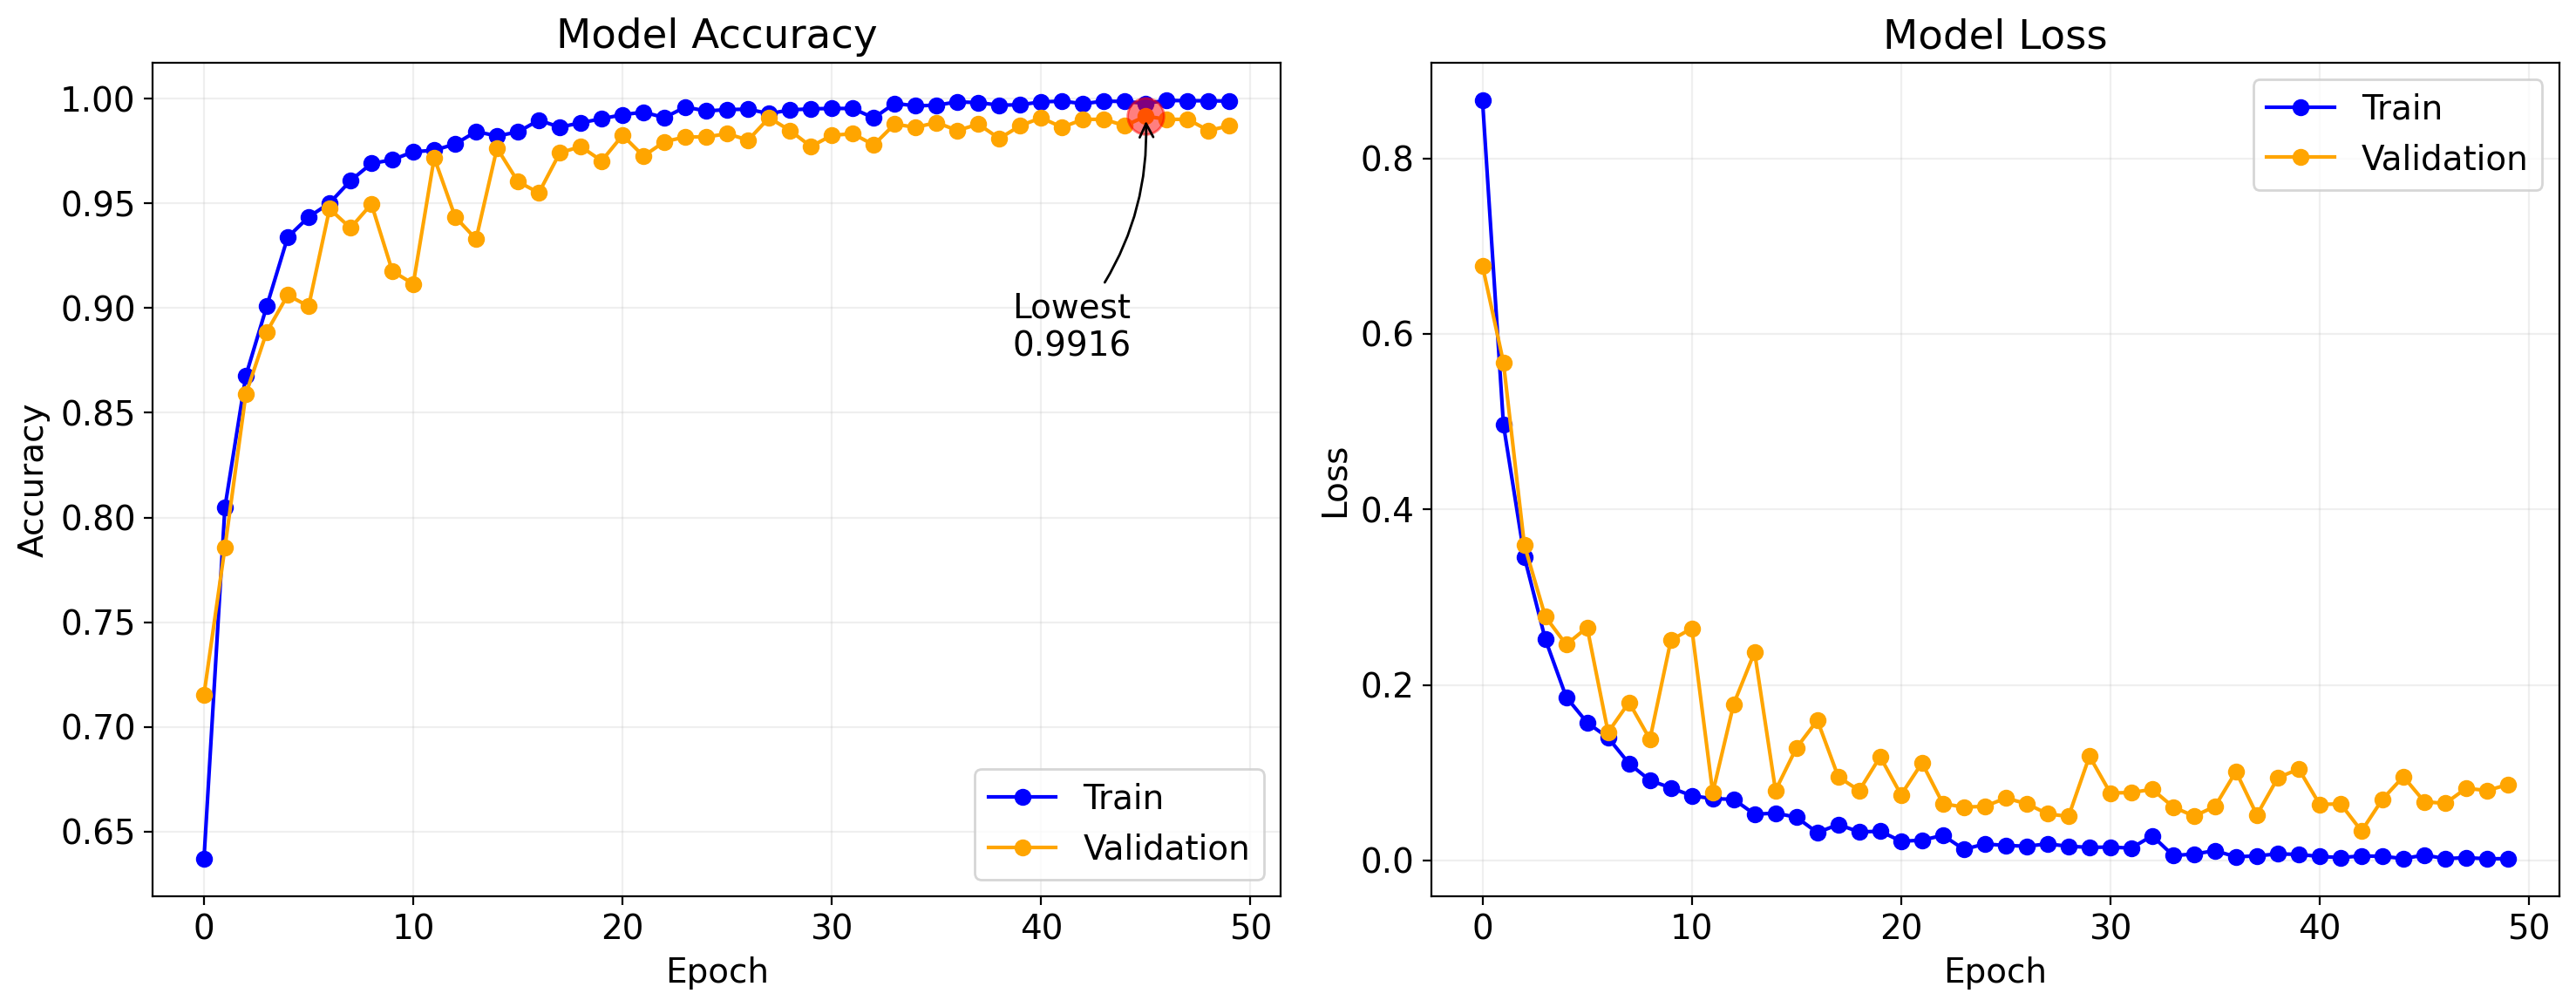

In [31]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plotting training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'], marker='o', linestyle='-', color='blue')
ax[0].plot(history.history['val_accuracy'], marker='o', linestyle='-', color='orange')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'], loc='lower right')
ax[0].grid(alpha=0.2)

# Plotting training and validation loss over epochs
ax[1].plot(history.history['loss'], marker='o', linestyle='-', color='blue')
ax[1].plot(history.history['val_loss'], marker='o', linestyle='-', color='orange')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'], loc='upper right')
ax[1].grid(alpha=0.2)

# Highlight lowest validation accuracy
min_val_acc_epoch = np.argmax(history.history['val_accuracy'])
min_val_acc = np.max(history.history['val_accuracy'])
ax[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
ax[0].annotate(f'Lowest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc), 
               xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

In [32]:
# Using test data for true labels and predictions
true_labels = []
predicted_labels = []

# Iterate over dataset to collect predictions and true labels
# Unbatch to get sample-wise prediction
for images, labels in test_ds_preprocessed.unbatch():  
    # Store true labels (Convert one-hot to index)
    true_label = np.argmax(labels.numpy()) 
    true_labels.append(true_label)
    
    # Get model prediction (Predict expects batch dimension)
    pred = model.predict(tf.expand_dims(images, 0), verbose=False)  
    predicted_label = np.argmax(pred)
    predicted_labels.append(predicted_label)

2024-07-13 18:45:42.598284: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [33]:
def plot_confusion_matrix(true_labels, predicted_labels, class_mappings, metrics=False, cmap='Blues'):
    # Compute  confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Mapping of indices to class names in class_mappings
    plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=class_mappings.keys(), ha='center')
    plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=class_mappings.keys(), va='center')
    plt.show()

    if metrics:
        # Precision, Recall, and F1-Score for each class & Overall accuracy
        precision = np.diag(cm) / np.sum(cm, axis=0)
        recall = np.diag(cm) / np.sum(cm, axis=1)
        f1_scores = 2 * precision * recall / (precision + recall)
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)

        print("Class-wise metrics:")
        for i in range(len(class_mappings)):
            class_name = list(class_mappings.keys())[i]
            print(f"\033[94mClass: {class_name}\033[0m")
            print(f"Precision: {precision[i]:.4f}")
            print(f"Recall: {recall[i]:.4f}")
            print(f"F1-Score: {f1_scores[i]:.4f}\n")

        print(f"\033[92mOverall Accuracy: {accuracy:.4f}\033[0m")

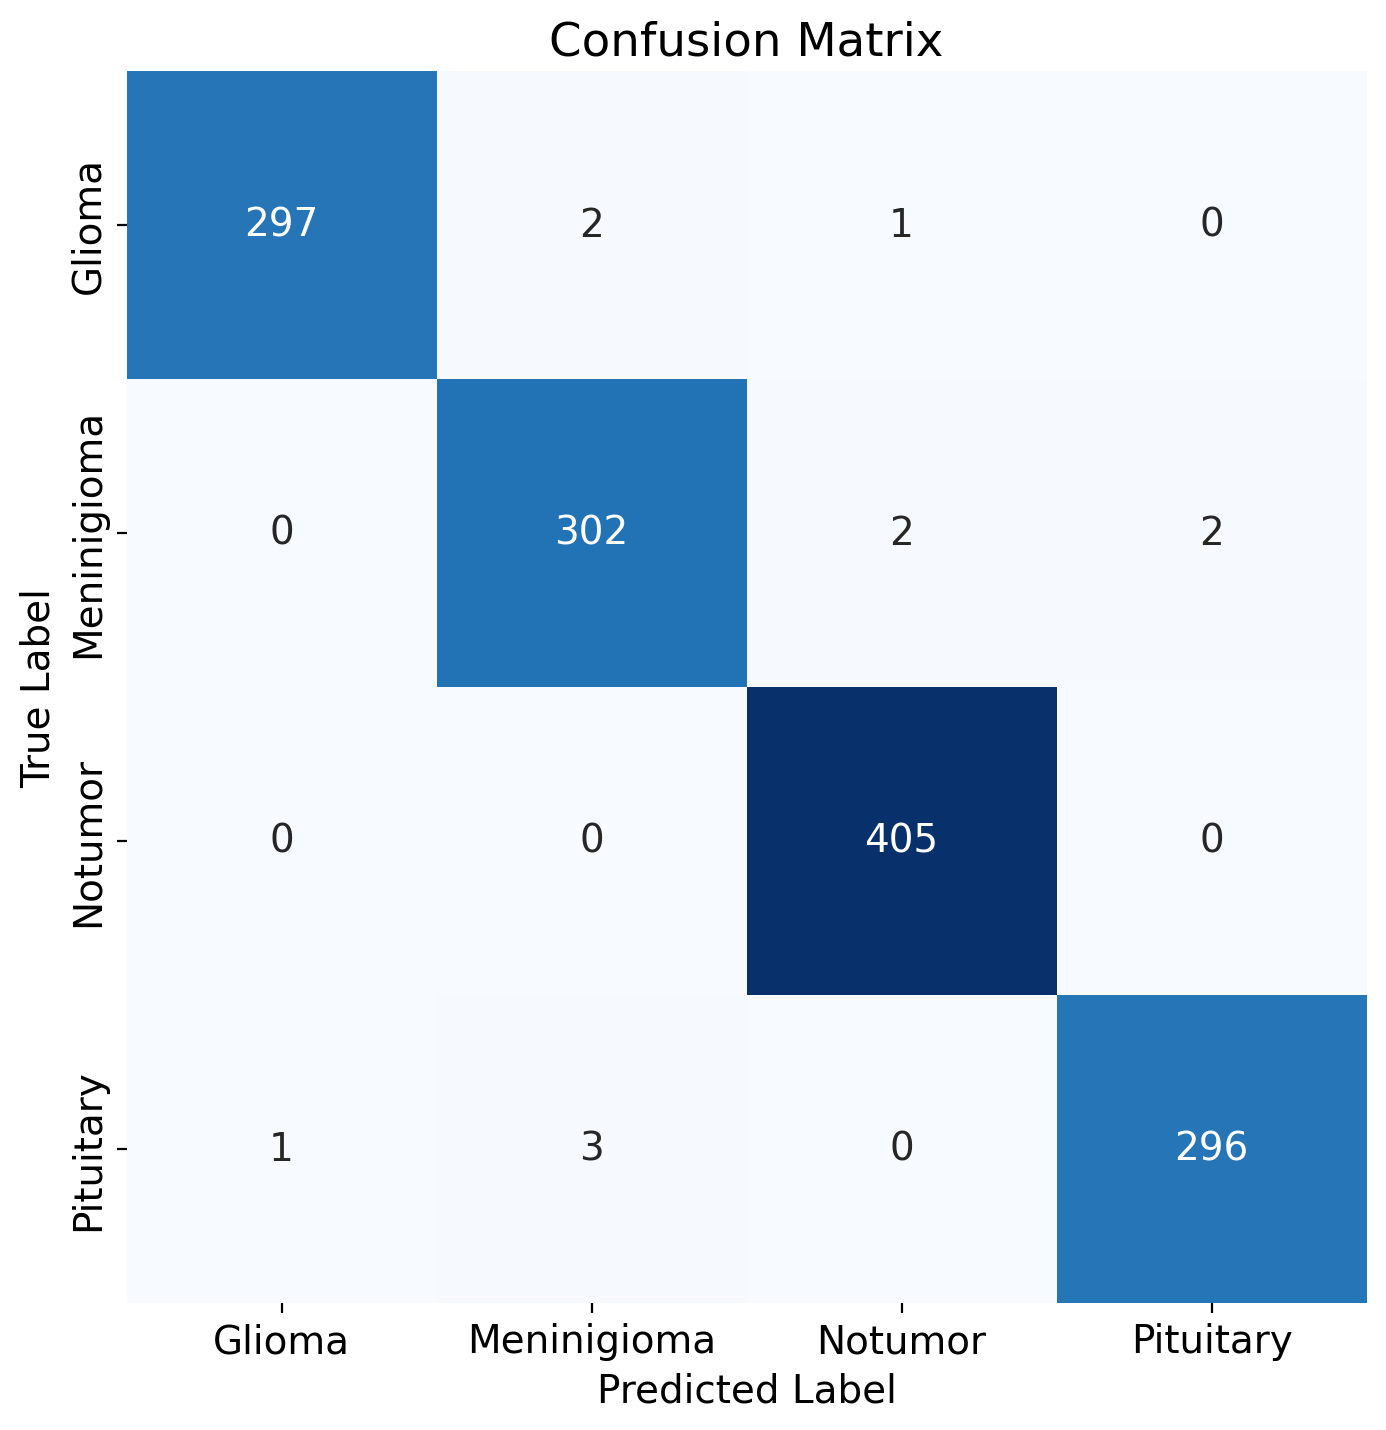

Class-wise metrics:
Class: Glioma
Precision: 0.9966
Recall: 0.9900
F1-Score: 0.9933

Class: Meninigioma
Precision: 0.9837
Recall: 0.9869
F1-Score: 0.9853

Class: Notumor
Precision: 0.9926
Recall: 1.0000
F1-Score: 0.9963

Class: Pituitary
Precision: 0.9933
Recall: 0.9867
F1-Score: 0.9900

Overall Accuracy: 0.9916


In [34]:
# Confusion matrix and metrics from predictions
plot_confusion_matrix(true_labels,
                      predicted_labels, 
                      class_mappings,
                      metrics=True)

In [35]:
def plot_sample_predictions(model, dataset, index_to_class, num_samples=9, figsize=(13, 12)):
    plt.figure(figsize=figsize)
    num_rows = num_cols = int(np.sqrt(num_samples))
    
    iterator = iter(dataset.unbatch())

    for i in range(1, num_samples + 1):
        image, true_label = next(iterator)
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        predicted_label = np.argmax(predictions, axis=1)[0]

        true_class_index = np.argmax(true_label.numpy())
        true_class = index_to_class[true_class_index]
        predicted_class = index_to_class[predicted_label]

        # Determine title color based on prediction accuracy
        title_color = 'green' if true_class_index == predicted_label else 'red'

        plt.subplot(num_rows, num_cols, i)
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.title(f"True: {true_class}\nPred: {predicted_class}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

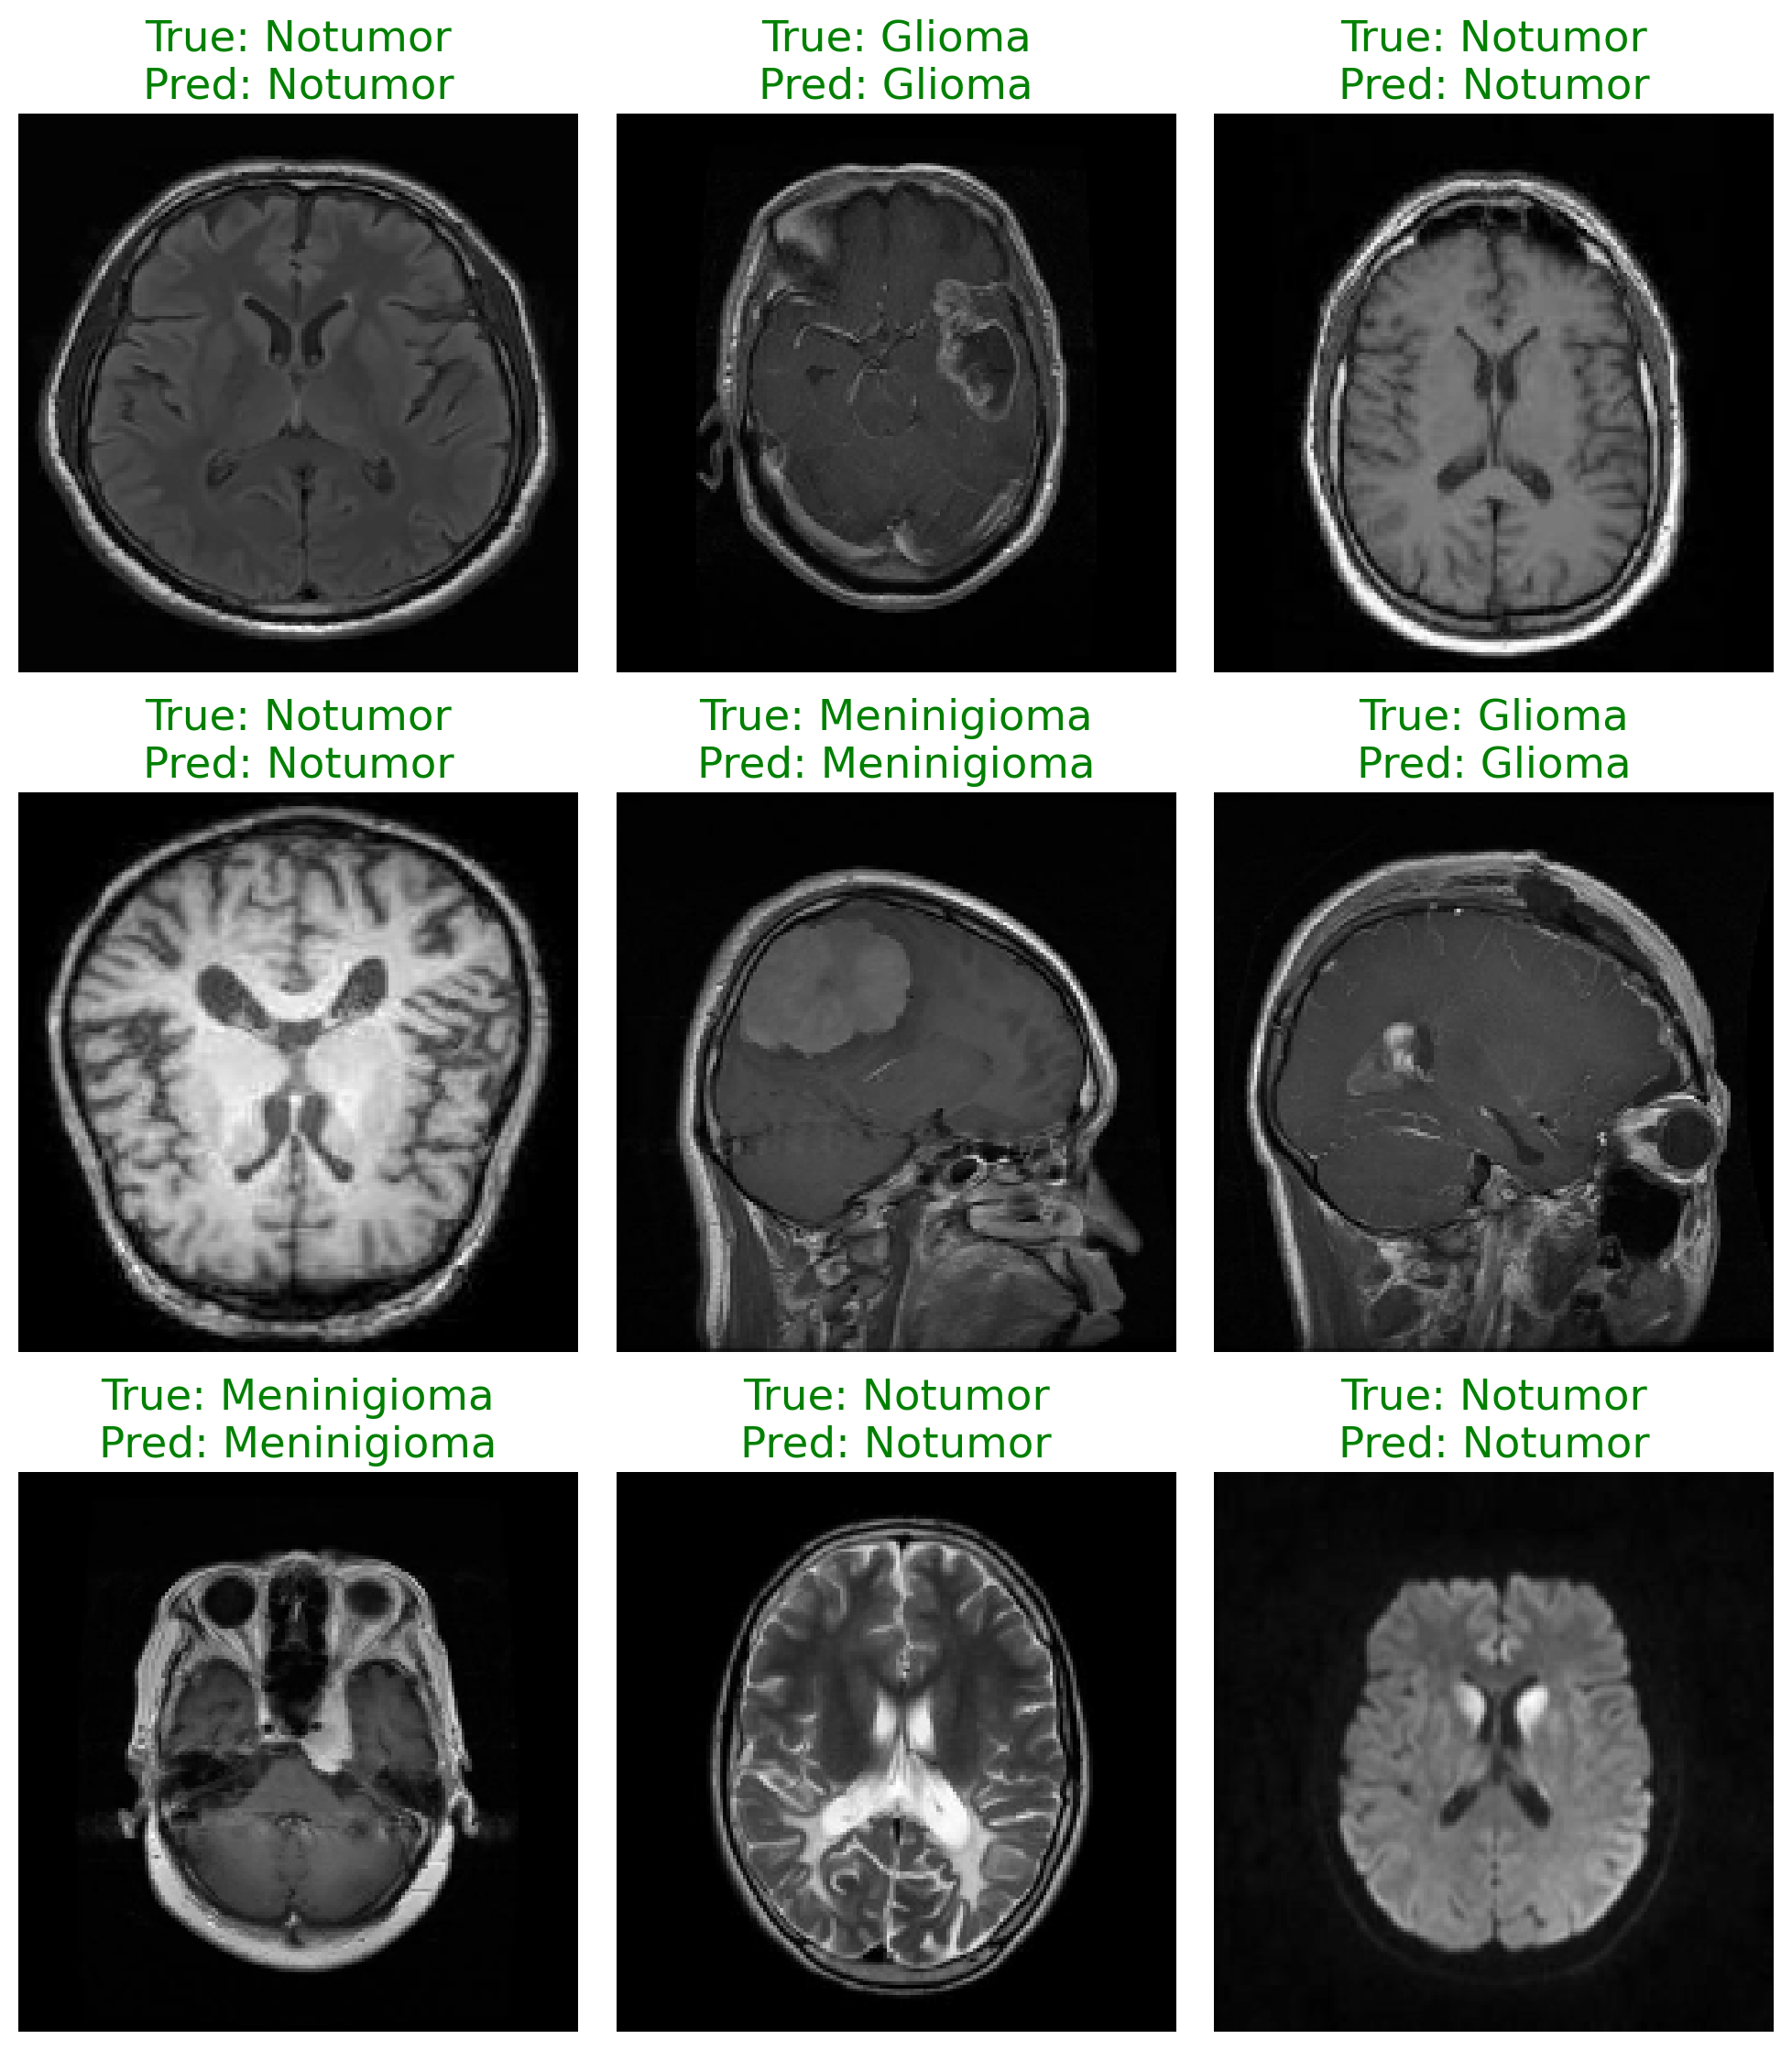

In [36]:
# Plotting samples with predictions
plot_sample_predictions(model=model,
                        dataset=test_ds_preprocessed, 
                        index_to_class=inv_class_mappings, 
                        num_samples=9,
                        figsize=(10, 11.5))

## Misclassified Tumors

In [37]:
def plot_misclassified_samples(model, dataset, index_to_class, figsize=(10, 10)):
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []
    
    # Iterate over dataset to collect misclassified images
    for image, true_label in dataset.unbatch():
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        predicted_label = np.argmax(predictions, axis=1)[0]
        true_class_index = np.argmax(true_label.numpy())
        
        if true_class_index != predicted_label:
            misclassified_images.append(image.numpy().squeeze())
            misclassified_labels.append(index_to_class[true_class_index])
            misclassified_predictions.append(index_to_class[predicted_label])

    # Determine number of rows and columns for subplot
    num_misclassified = len(misclassified_images)
    cols = int(np.sqrt(num_misclassified)) + 1
    rows = num_misclassified // cols + (num_misclassified % cols > 0)

    # Plotting misclassified images
    miss_classified_zip = zip(misclassified_images, misclassified_labels, misclassified_predictions)
    plt.figure(figsize=figsize)
    for i, (image, true_label, predicted_label) in enumerate(miss_classified_zip):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color='red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

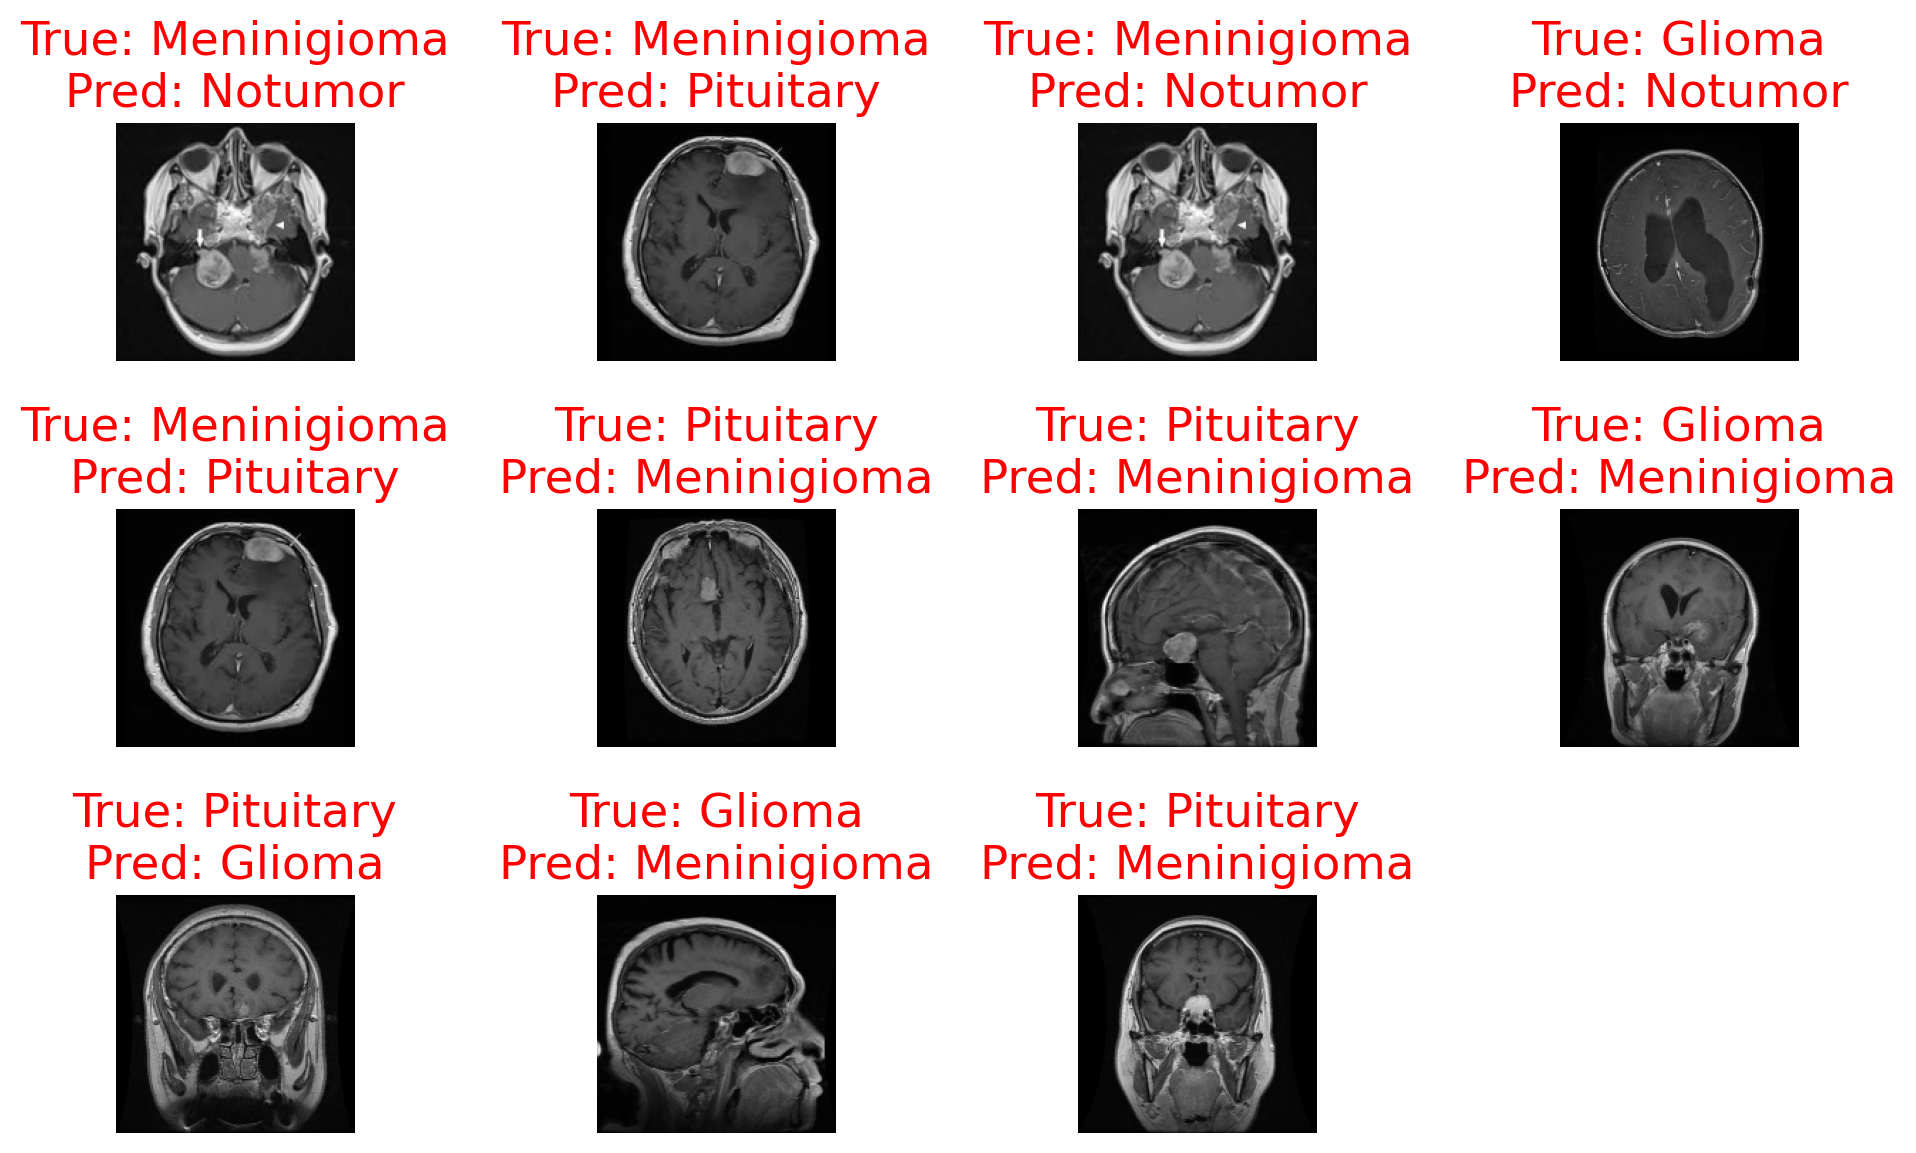

In [38]:
# Plotting misclassified images
plot_misclassified_samples(model=model,
                           dataset=test_ds_preprocessed, 
                           index_to_class=inv_class_mappings,
                           figsize=(10, 6))

## Testing on New Data

In [39]:
# Function to load and preprocess an image
def load_and_preprocess_image(image_path, image_shape=(168, 168)):
    img = image.load_img(image_path, target_size=image_shape, color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add the batch dimension
    return img_array

# Function to display a row of images with predictions
def display_images_and_predictions(image_paths, predictions, true_labels, figsize=(20, 5)):
    plt.figure(figsize=figsize)
    for i, (image_path, prediction, true_label) in enumerate(zip(image_paths, predictions, true_labels)):
        ax = plt.subplot(1, len(image_paths), i + 1)
        img_array = load_and_preprocess_image(image_path)
        img_array = np.squeeze(img_array)
        plt.imshow(img_array, cmap='gray')
        title_color = 'green' if prediction == true_label else 'red'
        plt.title(f'True Label: {true_label}\nPred: {prediction}', color=title_color)
        plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Class Mappings: {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}

Normal Image Prediction: [0. 0. 1. 0.]
Glioma Image Prediction: [1. 0. 0. 0.]
Meningioma Image Prediction: [0. 1. 0. 0.]
Pituitary Image Prediction: [0. 0. 0. 1.]


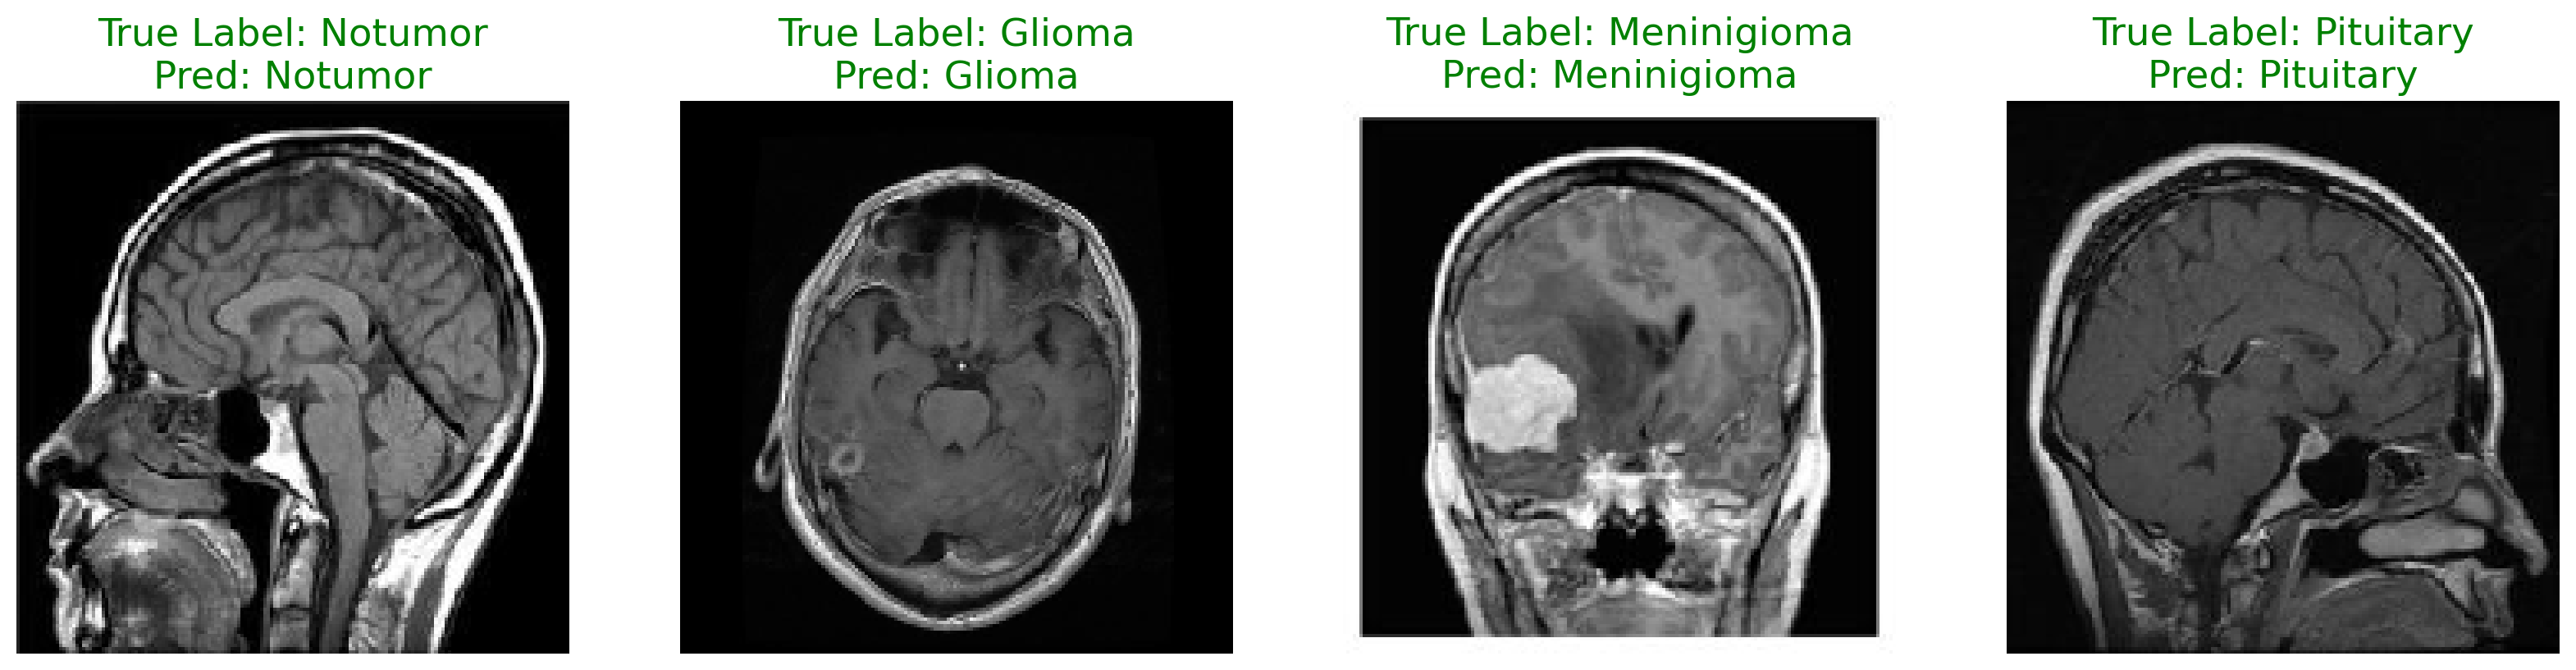

In [40]:
# Load and preprocess the images
normal_image_path = 'Data/Normal/N_100.jpg'
glioma_image_path = 'Data/Tumor/glioma_tumor/G_10.jpg'
meningioma_image_path = 'Data/Tumor/meningioma_tumor/M_101_HF_.jpg'
pituitary_tumor_path = 'Data/Tumor/pituitary_tumor/P_100_HF_.jpg'

# Image paths
image_paths = [
    normal_image_path,
    glioma_image_path,
    meningioma_image_path,
    pituitary_tumor_path
]

# True labels for images
true_labels = ['Notumor', 'Glioma', 'Meninigioma', 'Pituitary']

# Load and preprocess images, then make predictions
images = [load_and_preprocess_image(path) for path in image_paths]
predictions = [model.predict(image) for image in images]

# Determine the predicted labels
predicted_labels = [inv_class_mappings[np.argmax(one_hot)] for one_hot in predictions]

# Output the predictions
print(f'Class Mappings: {class_mappings}')
print("\nNormal Image Prediction:", np.round(predictions[0], 3)[0])
print("Glioma Image Prediction:", np.round(predictions[1], 3)[0])
print("Meningioma Image Prediction:", np.round(predictions[2], 3)[0])
print("Pituitary Image Prediction:", np.round(predictions[3], 3)[0])

# Display images with predictions
display_images_and_predictions(image_paths, predicted_labels, true_labels)